# Classification Analysis on House Prices

We will divide the house prices in three categories and then try to predict those

Author: Julia Hammerer, Vanessa Mai <br>
Last Changes: 10.12.2018

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split, KFold
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
from matplotlib import pyplot as plt
from sklearn.metrics import roc_curve, auc
from xgboost import XGBClassifier,plot_importance
import itertools
from scipy import interp
from sklearn import svm
from sklearn.dummy import DummyClassifier

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Function Definitions

In [3]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## Data Prep

In [4]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [5]:
df=pd.read_csv("../data/house_prices_train.csv")
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [6]:
df = df.drop(columns=["Id","Street","Utilities"])

In [7]:
# create new column
def price_class(row):
    if row["SalePrice"]<=120000:
        return "low"
    elif (row["SalePrice"]>120000)& (row["SalePrice"]<=250000):
        return "middle"
    else:
        return"upper"


df["Price_Class"]= df.apply(lambda row: price_class(row), axis=1)

In [8]:
# df = df.replace({"low":0,"middle":1,"upper":2})

In [9]:
df=df.fillna(0)
df.drop(columns=["SalePrice"], inplace=True)

In [10]:
# we have to encode our categorical data
cols_to_transform= df.drop(columns=["Price_Class"]).select_dtypes(include='object').columns.values
df_hot1encoded= pd.get_dummies(df, columns=cols_to_transform, prefix=cols_to_transform, drop_first=True)

In [11]:
df_hot1encoded.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,Price_Class,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Alley_Grvl,Alley_Pave,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_HLS,LandContour_Low,LandContour_Lvl,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_TA,BsmtCond_Fa,BsmtCond_Gd,BsmtCond_Po,BsmtCond_TA,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_ALQ,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_Rec,BsmtFinType2_Unf,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_Y,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,FireplaceQu_Ex,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_Po,FireplaceQu_TA,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageFinish_Fin,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Ex,GarageQual_Fa,GarageQual_Gd,GarageQual_Po,GarageQual_TA,GarageCond_Ex,GarageCond_Fa,GarageCond_Gd,GarageCond_Po,GarageCond_TA,PavedDrive_P,PavedDrive_Y,PoolQC_Ex,PoolQC_Fa,PoolQC_Gd,Fence_GdPrv,Fence_GdWo,Fence_MnPrv,Fence_MnWw,MiscFeature_Gar2,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca

In [12]:
df_hot1encoded= df_hot1encoded.fillna(0)
display(df_hot1encoded.head())
print(df_hot1encoded.shape)

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,Price_Class,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Alley_Grvl,Alley_Pave,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_HLS,LandContour_Low,LandContour_Lvl,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_TA,BsmtCond_Fa,BsmtCond_Gd,BsmtCond_Po,BsmtCond_TA,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_ALQ,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_Rec,BsmtFinType2_Unf,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_Y,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,FireplaceQu_Ex,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_Po,FireplaceQu_TA,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageFinish_Fin,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Ex,GarageQual_Fa,GarageQual_Gd,GarageQual_Po,GarageQual_TA,GarageCond_Ex,GarageCond_Fa,GarageCond_Gd,GarageCond_Po,GarageCond_TA,PavedDrive_P,PavedDrive_Y,PoolQC_Ex,PoolQC_Fa,PoolQC_Gd,Fence_GdPrv,Fence_GdWo,Fence_MnPrv,Fence_MnWw,MiscFeature_Gar2,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca

(1460, 260)


In [13]:
featureCols=df_hot1encoded.columns.tolist()
featureCols.remove("Price_Class")

targetCol=df_hot1encoded["Price_Class"]

In [14]:
X= df_hot1encoded[featureCols].values
y= df_hot1encoded["Price_Class"].values

In [15]:
scaler= StandardScaler()
scaler.fit_transform(X)

array([[ 0.07337496,  0.2128772 , -0.20714171, ..., -0.11785113,
         0.4676514 , -0.30599503],
       [-0.87256276,  0.64574726, -0.09188637, ..., -0.11785113,
         0.4676514 , -0.30599503],
       [ 0.07337496,  0.29945121,  0.07347998, ..., -0.11785113,
         0.4676514 , -0.30599503],
       ...,
       [ 0.30985939,  0.2417352 , -0.14781027, ..., -0.11785113,
         0.4676514 , -0.30599503],
       [-0.87256276,  0.29945121, -0.08016039, ..., -0.11785113,
         0.4676514 , -0.30599503],
       [-0.87256276,  0.50145724, -0.05811155, ..., -0.11785113,
         0.4676514 , -0.30599503]])

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)


## Baseline Model
Using the simplest model (most-frequent class ) as a baseline, which we want to beat. The baseline predicts all as middle class.

In [17]:
baseline_clf = DummyClassifier(strategy='most_frequent', random_state=0)
baseline_clf.fit(X_train, y_train)

DummyClassifier(constant=None, random_state=0, strategy='most_frequent')

## Model Comparison
in order to compare the models, we will save the models and the CV-results in a list:


In [18]:
opt_models = []

In [19]:
# add the baseline model
opt_models.append(("Baseline", baseline_clf))

## Logistic Regression Iteration 1

In [20]:
pipe1 = Pipeline([('stdSc', StandardScaler()),
                 ('clf', LogisticRegression(C=0.1,random_state=1)) 
                ])

In [21]:
pipe1.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('stdSc', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=1, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))])

In [22]:
y_pred=pipe1.predict(X_test)


In [23]:
print('Training Accuracy: %.3f' % pipe1.score(X_train, y_train)) 
print('Test Accuracy: %.3f' % pipe1.score(X_test, y_test)) 

Training Accuracy: 0.938
Test Accuracy: 0.824


[[ 50  19   0]
 [ 20 261  19]
 [  0  19  50]]
Confusion matrix, without normalization
[[ 50  19   0]
 [ 20 261  19]
 [  0  19  50]]


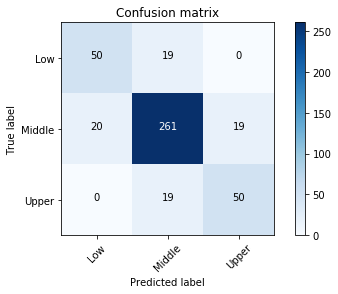

In [24]:
class_names = ('Low', 'Middle', 'Upper')

confusion_mat = confusion_matrix(y_test, y_pred)
print(confusion_mat)
plot_confusion_matrix(confusion_mat, classes=class_names)

In [25]:
print ("Accuracy:       ",accuracy_score(y_test, y_pred))
print ("Precision:      ",precision_score(y_test, y_pred,average=None))
print ("Recall:         ",recall_score(y_test, y_pred,average=None))
print ("F1-Score:       ",f1_score(y_test, y_pred,average=None))

Accuracy:        0.8242009132420092
Precision:       [0.71428571 0.8729097  0.72463768]
Recall:          [0.72463768 0.87       0.72463768]
F1-Score:        [0.71942446 0.87145242 0.72463768]


Results for the `Middle Class`is better than the others. This is expected, since there are more samples for that class. Overall, the results are somewhat good. Let's try optimizing it all a bit. 

## Logistic Regression Iteration 2
Gridsearch plus CV

In [26]:
pipe1.get_params

<bound method Pipeline.get_params of Pipeline(memory=None,
     steps=[('stdSc', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=1, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))])>

In [27]:
# since newton-cg and saga only accepts l2 penalty, we will only use that in the gridsearch
penalties=["l2"]
c=np.logspace(-4, 0, 40)
solvers = ["newton-cg", "sag", "saga", "lbfgs"]

param_grid_lr={'clf__penalty' : penalties,
            'clf__C' :c,
              'clf__solver': solvers}

In [28]:
lr_randSearch = RandomizedSearchCV(estimator=pipe1, param_distributions=param_grid_lr,scoring='accuracy',cv=10, n_iter=8)
lr_randSearch.fit(X_train, y_train)


C:\Users\maiv2\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\maiv2\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\maiv2\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\maiv2\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\maiv2\AppData\Local\Continuum\anaconda3\lib\sit

RandomizedSearchCV(cv=10, error_score='raise-deprecating',
          estimator=Pipeline(memory=None,
     steps=[('stdSc', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=1, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))]),
          fit_params=None, iid='warn', n_iter=8, n_jobs=None,
          param_distributions={'clf__penalty': ['l2'], 'clf__C': array([1.00000e-04, 1.26638e-04, 1.60372e-04, 2.03092e-04, 2.57191e-04,
       3.25702e-04, 4.12463e-04, 5.22335e-04, 6.61474e-04, 8.37678e-04,
       1.06082e-03, 1.34340e-03, 1.70125e-03, 2.15443e-03, 2.72833e-03,
       3.45511e-03, 4.37548e-...e-01, 6.23551e-01, 7.89652e-01, 1.00000e+00]), 'clf__solver': ['newton-cg', 'sag', 'saga', 'lbfgs']},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
  

In [29]:
print("Best Configuration found by Grid Search")
print(lr_randSearch.best_score_)
print(lr_randSearch.best_params_)
print(lr_randSearch.best_estimator_)

Best Configuration found by Grid Search
0.8405088062622309
{'clf__solver': 'newton-cg', 'clf__penalty': 'l2', 'clf__C': 0.022854638641349907}
Pipeline(memory=None,
     steps=[('stdSc', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', LogisticRegression(C=0.022854638641349907, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=1,
          solver='newton-cg', tol=0.0001, verbose=0, warm_start=False))])


In [30]:
pipe2=lr_randSearch.best_estimator_
pipe2.fit(X_train, y_train)
y_pred=pipe2.predict(X_test)
confusion_mat=confusion_matrix(y_test, y_pred)
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("Recall: ",recall_score(y_test, y_pred,average=None))
print("Precision: ",precision_score(y_test, y_pred,average=None))
print("F1: ",f1_score(y_test, y_pred,average=None))
print(confusion_mat)

Accuracy:  0.8538812785388128
Recall:  [0.72463768 0.92666667 0.66666667]
Precision:  [0.76923077 0.86875    0.86792453]
F1:  [0.74626866 0.89677419 0.75409836]
[[ 50  19   0]
 [ 15 278   7]
 [  0  23  46]]


In [31]:
# add model to summary
opt_models.append(("Log Reg", pipe2.steps[1][1]))


Recall is not as good as the other scores. 

In [32]:
score=cross_val_score(pipe2, X, y, scoring="accuracy", cv=10)

In [33]:
score.mean()
print("Mean accuracy: %5.2f (+/-%5.2f) "%(score.mean(), score.std()))

Mean accuracy:  0.86 (+/- 0.02) 


Confusion matrix, without normalization
[[ 50  19   0]
 [ 15 278   7]
 [  0  23  46]]


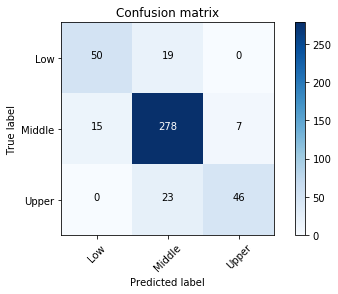

In [34]:
class_names = ('Low', 'Middle', 'Upper')

cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix')
plt.show()

### Feature Importance (LR)


In [35]:
LRImp=pd.DataFrame(index=featureCols, columns=["LR"])
LRImp["LR"]=pipe2.steps[1][1].coef_[0]
feature_imp=LRImp.sort_values(by="LR", ascending=False)

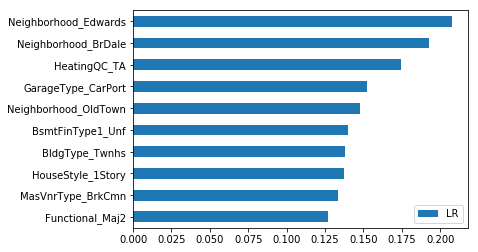

In [36]:
feature_imp.head(10).sort_values(by="LR", ascending=True).plot(kind="barh")

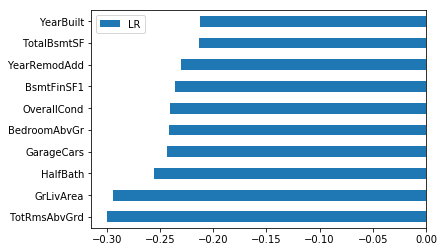

In [37]:
feature_imp.tail(10).sort_values(by="LR", ascending=True).plot(kind="barh")

## Logistic Regression Iteration 3
- used subset of feature based on previous Logistic Regression

In [38]:
sel_features=feature_imp[abs(feature_imp["LR"])>0.05].index.tolist()

In [39]:
pipe3 = Pipeline([('stdSc', StandardScaler()),
                 ('clf', LogisticRegression(C=0.1,random_state=1)) 
                ])

In [40]:
# since newton-cg and saga only accepts l2 penalty, we will only use that in the gridsearch
penalties=["l2"]
c=np.logspace(-4, 0, 40)
solvers = ["newton-cg", "sag", "saga", "lbfgs"]

param_grid_lr={'clf__penalty' : penalties,
            'clf__C' :c,
              'clf__solver': solvers}

In [41]:
lr_randSearch2 = RandomizedSearchCV(estimator=pipe3, param_distributions=param_grid_lr,scoring='accuracy',cv=10, n_iter=8)
lr_randSearch2.fit(X_train, y_train)


C:\Users\maiv2\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\maiv2\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\maiv2\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\maiv2\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\maiv2\AppData\Local\Continuum\anaconda3\lib\sit

RandomizedSearchCV(cv=10, error_score='raise-deprecating',
          estimator=Pipeline(memory=None,
     steps=[('stdSc', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=1, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))]),
          fit_params=None, iid='warn', n_iter=8, n_jobs=None,
          param_distributions={'clf__penalty': ['l2'], 'clf__C': array([1.00000e-04, 1.26638e-04, 1.60372e-04, 2.03092e-04, 2.57191e-04,
       3.25702e-04, 4.12463e-04, 5.22335e-04, 6.61474e-04, 8.37678e-04,
       1.06082e-03, 1.34340e-03, 1.70125e-03, 2.15443e-03, 2.72833e-03,
       3.45511e-03, 4.37548e-...e-01, 6.23551e-01, 7.89652e-01, 1.00000e+00]), 'clf__solver': ['newton-cg', 'sag', 'saga', 'lbfgs']},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
  

In [42]:
print("Best Configuration found by Grid Search")
print(lr_randSearch2.best_score_)
print(lr_randSearch2.best_params_)
print(lr_randSearch2.best_estimator_)

Best Configuration found by Grid Search
0.8405088062622309
{'clf__solver': 'lbfgs', 'clf__penalty': 'l2', 'clf__C': 0.38881551803080855}
Pipeline(memory=None,
     steps=[('stdSc', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', LogisticRegression(C=0.38881551803080855, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=1,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False))])


In [43]:
pipe3=lr_randSearch.best_estimator_
pipe3.fit(X_train, y_train)
y_pred=pipe3.predict(X_test)
confusion_mat=confusion_matrix(y_test, y_pred)
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("Recall: ",recall_score(y_test, y_pred,average=None))
print("Precision: ",precision_score(y_test, y_pred,average=None))
print("F1: ",f1_score(y_test, y_pred,average=None))


Accuracy:  0.8538812785388128
Recall:  [0.72 0.93 0.67]
Precision:  [0.77 0.87 0.87]
F1:  [0.75 0.9  0.75]


Confusion matrix, without normalization
[[ 50  19   0]
 [ 15 278   7]
 [  0  23  46]]


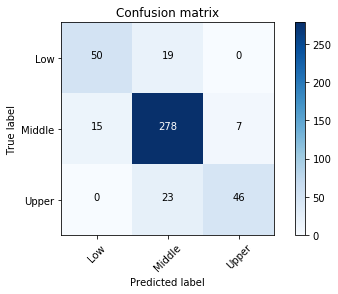

In [44]:
class_names = ('Low', 'Middle', 'Upper')

cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix')
plt.show()

Model did not improve much. Model can differentiate between low and high very well. For distinguishing between middle and low or middle and upper it has a little more difficulty.

## SVM

In [45]:
pipe_svm1 = Pipeline([('stdSc', StandardScaler()),
                 ('clf', svm.SVC() )
                ])

In [46]:
pipe_svm1.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('stdSc', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False))])

In [47]:
y_pred=pipe_svm1.predict(X_test)


In [48]:
print('Training Accuracy: %.3f' % pipe_svm1.score(X_train, y_train)) 
print('Test Accuracy: %.3f' % pipe_svm1.score(X_test, y_test)) 

Training Accuracy: 0.960
Test Accuracy: 0.861


Confusion matrix, without normalization
[[ 41  28   0]
 [  5 293   2]
 [  0  26  43]]


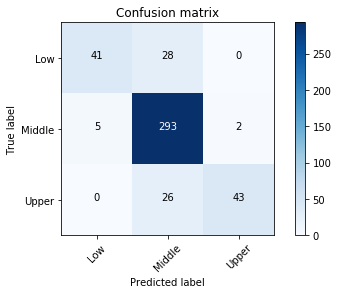

In [49]:
cnf_mat = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cnf_mat,class_names)

In [50]:
print ("Accuracy:       ",accuracy_score(y_test, y_pred))
print ("Precision:      ",precision_score(y_test, y_pred,average=None))
print ("Recall:         ",recall_score(y_test, y_pred,average=None))
print ("F1-Score:       ",f1_score(y_test, y_pred,average=None))

Accuracy:        0.860730593607306
Precision:       [0.89 0.84 0.96]
Recall:          [0.59 0.98 0.62]
F1-Score:        [0.71 0.91 0.75]


## SVM iteration 2
Let's try optimizing this model


In [51]:
pipe_svm1.get_params().keys()

dict_keys(['memory', 'steps', 'stdSc', 'clf', 'stdSc__copy', 'stdSc__with_mean', 'stdSc__with_std', 'clf__C', 'clf__cache_size', 'clf__class_weight', 'clf__coef0', 'clf__decision_function_shape', 'clf__degree', 'clf__gamma', 'clf__kernel', 'clf__max_iter', 'clf__probability', 'clf__random_state', 'clf__shrinking', 'clf__tol', 'clf__verbose'])

In [52]:
param_grid_svm = [
 {'clf__C': [1, 10, 100, 1000], 'clf__kernel': ['linear']},
 {'clf__C': [1, 10, 100, 1000], 'clf__gamma': [0.001, 0.0001], 'clf__kernel': ['rbf']},
]

In [53]:
svm_GridSearch = GridSearchCV(estimator=pipe_svm1, param_grid=param_grid_svm,scoring='accuracy',cv=10)
svm_GridSearch.fit(X_train, y_train)


GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('stdSc', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'clf__C': [1, 10, 100, 1000], 'clf__kernel': ['linear']}, {'clf__C': [1, 10, 100, 1000], 'clf__gamma': [0.001, 0.0001], 'clf__kernel': ['rbf']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [54]:
print("Best Configuration found by Grid Search")
print(svm_GridSearch.best_score_)
print(svm_GridSearch.best_params_)
print(svm_GridSearch.best_estimator_)

Best Configuration found by Grid Search
0.8649706457925636
{'clf__C': 10, 'clf__gamma': 0.001, 'clf__kernel': 'rbf'}
Pipeline(memory=None,
     steps=[('stdSc', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])


In [55]:
pipe_svm2=svm_GridSearch.best_estimator_
pipe_svm2.fit(X_train, y_train)
y_pred=pipe_svm2.predict(X_test)
confusion_mat=confusion_matrix(y_test, y_pred)
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("Recall: ",recall_score(y_test, y_pred,average=None))
print("Precision: ",precision_score(y_test, y_pred,average=None))
print("F1: ",f1_score(y_test, y_pred,average=None))


Accuracy:  0.8515981735159818
Recall:  [0.75 0.9  0.72]
Precision:  [0.72 0.88 0.85]
F1:  [0.74 0.89 0.78]


Confusion matrix, without normalization
[[ 52  17   0]
 [ 20 271   9]
 [  0  19  50]]


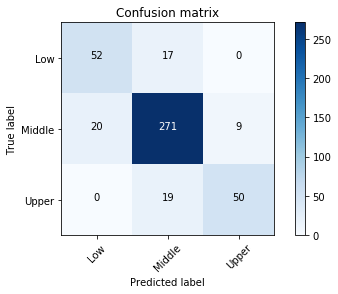

In [56]:

cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix')
plt.show()

In [57]:
# add model to summary
opt_models.append(("SVM", pipe_svm2.steps[1][1]))


## XGBoost

In [58]:
X_train = pd.DataFrame(data=X_train, columns=featureCols)
X_test = pd.DataFrame(data=X_test, columns=featureCols)

In [59]:
xgb= XGBClassifier(max_depth=4, learning_rate=0.05, n_estimators=200,
                   objective='multi:softprob', gamma=0., 
                   max_delta_step=0., subsample=0.9, colsample_bytree=0.9,
                   seed=0)  
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.9, gamma=0.0, learning_rate=0.05,
       max_delta_step=0.0, max_depth=4, min_child_weight=1, missing=None,
       n_estimators=200, n_jobs=1, nthread=None,
       objective='multi:softprob', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=0, silent=True,
       subsample=0.9)

In [60]:
# make predictions for test data
y_pred = xgb.predict(X_test)

In [61]:
print('Training Accuracy: %.3f' % xgb.score(X_train, y_train)) 
print('Test Accuracy: %.3f' % xgb.score(X_test, y_test))

Training Accuracy: 0.995
Test Accuracy: 0.895


Confusion matrix, without normalization
[[ 58  11   0]
 [ 11 283   6]
 [  0  18  51]]


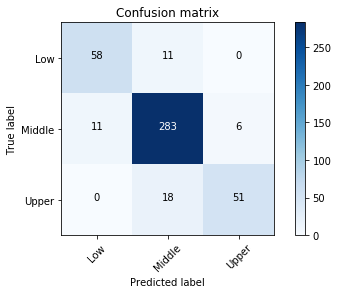

In [62]:
class_names = ('Low', 'Middle', 'Upper')

confusion_mat = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(confusion_mat, classes=class_names, title='Confusion matrix')

In [63]:
print ("Accuracy:       ",accuracy_score(y_test, y_pred))
print ("Precision:      ",precision_score(y_test, y_pred,average=None))
print ("Recall:         ",recall_score(y_test, y_pred,average=None))
print ("F1-Score:       ",f1_score(y_test, y_pred,average=None))

Accuracy:        0.8949771689497716
Precision:       [0.84 0.91 0.89]
Recall:          [0.84 0.94 0.74]
F1-Score:        [0.84 0.92 0.81]


As expected, we can see that the "Middle" Priceclass can be predicted best. The Accuracy with the XGBoost is the best so far. Nevertheless we try to optimize our model with a Gridsearch.

### Feature Importance XGBoost

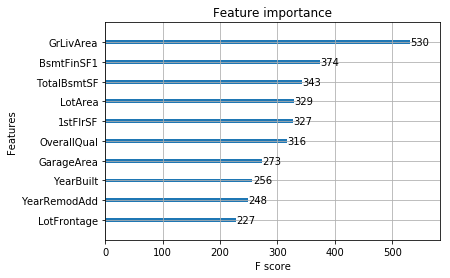

In [64]:
plot_importance(xgb,max_num_features=10)
plt.show()

In [65]:

opt_models.append(("XGBoost", xgb))

### Hyperparameter tuning

We apply a gridsearch to see if we can tune our parameters for a better accuracy.

In [66]:
param_test = {
 'max_depth':[4,5,6],
 'min_child_weight':[4,5,6],
 'colsample_bytree':[0.1,0.4,0.6],
}

gsearch = GridSearchCV(estimator = XGBClassifier(learning_rate=0.1, n_estimators=140, max_depth=5,
                         min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
                         objective= 'multi:softprob', nthread=4, scale_pos_weight=1,seed=27), 
                         param_grid = param_test,n_jobs=4,iid=False, cv=5)


In [67]:
model2 = gsearch.fit(X_train, y_train)


In [68]:
y_pred = model2.predict(X_test)

Confusion matrix, without normalization
[[ 56  13   0]
 [ 12 283   5]
 [  0  18  51]]


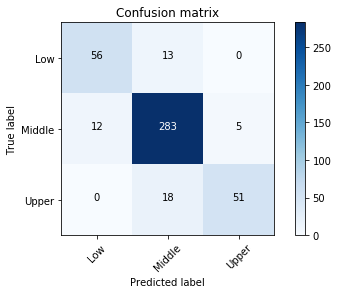

In [69]:
class_names = ('Low', 'Middle', 'Upper')

confusion_mat = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(confusion_mat, classes=class_names, title='Confusion matrix')

In [70]:
print ("Accuracy:       ",accuracy_score(y_test, y_pred))
print ("Precision:      ",precision_score(y_test, y_pred,average=None))
print ("Recall:         ",recall_score(y_test, y_pred,average=None))
print ("F1-Score:       ",f1_score(y_test, y_pred,average=None))

Accuracy:        0.8904109589041096
Precision:       [0.82 0.9  0.91]
Recall:          [0.81 0.94 0.74]
F1-Score:        [0.82 0.92 0.82]


We see that the Accuracy has not changed much. Also our other metrics did not really optimize.

## Comparison of Models

Baseline: 0.667123 (0.046373)


C:\Users\maiv2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:462: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\maiv2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\maiv2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:462: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\maiv2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\maiv2\AppData\Local\Continuum\anaconda3\lib\site-pa

C:\Users\maiv2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:462: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\maiv2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\maiv2\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\Users\maiv2\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\Users\maiv2\AppData\Local\Continuum\anaconda3\lib\site-packages\skl

Log Reg: 0.865068 (0.025637)
SVM: 0.669863 (0.047532)
XGBoost: 0.880137 (0.023578)


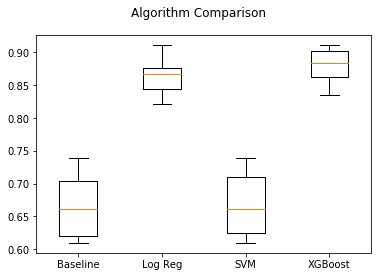

In [71]:
seed=7
# evaluate each model in turn
opt_results = []
opt_names = []
scoring = 'accuracy'
for name, model in opt_models:
    kfold = KFold(n_splits=10, random_state=seed)
    cv_results = cross_val_score(model, X, y, cv=kfold, scoring=scoring)
    opt_results.append(cv_results)
    opt_names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(opt_results)
ax.set_xticklabels(opt_names)
plt.show()

Out of the models we have tested, XGBoost performs the best and the SVM is the worst. 
In general, we still achieve pretty good result. The classificatin works quite well. Especially distinguishing low and upper SalePrices is not a problem. The model only mixes the two classes with the middle class, but never with each other, which makes sense and confirms that we can easly distinguish the two classes low and upper. Like in the regression task, we could have also tweak the model even more by applying some feature reduction techniques, like forward and backward elimination or RFE. One thing to be careful about is to not rely on Accuracy only but to also look at Recall and Precision. We are dealing with an imbalanced dataset, which means if we are always predicting the most common class, we might be tricked by the high accuracy. 

In general, in classification problems, machine learning seems to be more tangible. For regression tasks, there are also more different models that can be used, like OLS, GLS, Lasso, etc. Here, we felt like being quite limited. 

The models do provide some insights on the features as well and how they are contributing to the outcome. GrLivArea, BsmtFinSF1 and total TotalBsmtSF are identified in the Logistic Regression as well as in XGBoost, which means we can safely confirm that they are indeed important. The Logistic Regression though, also identifies some of the Neighborhood categories as important, for which we will have a deeper look in the significance testing (different notebook). Both approaches, Regression and XGBoosts help us understand more about the attributes. However, LogReg goes a little further, as it can tell if an attribute is affecting the target in a positive or negative way. 